In today's post, we will explore ways to build machine learning pipelines with Scikit-learn. A pipeline might sound like a big word, but it's just a way of chaining different operations together in a convenient object, almost like a wrapper. This abstracts out a lot of individual operations that may otherwise appear fragmented across the script. I also personally think that Scikit-learn's ML pipeline is very well-designed. So here is a brief introduction to ML pipelines is Scikit-learn. 

# Setup

For the purposes of this tutorial, we will be using the classic Titanic dataset, otherwise known as the course material for Kaggle 101. I'm still trying to get my feet into Kaggle, so it is my hope that this tutorial will also help those trying to break into data science competitions. 

First, let's import the modules and datasets needed for this tutorial.

## Importing Dependencies

Scikit-learn is the go-to library for machine learning in Python. It contains not only data loading utilities, but also imputers, encoders, pipelines, transformers, and search tools we will need to find the optimum model for the task.

In [0]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

## Loading the Data

Let's load the dataset using `fetch_openml`.

In [0]:
np.random.seed(42)

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Let's observe the data by calling `.head()`. By default, this shows us the first five rows and as many columns as it can fit within the notebook. 

In [3]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0.0,0.0,383123,7.7500,None,Q
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1.0,0.0,SC/PARIS 2167,27.7208,None,C
628,3.0,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4.0,2.0,347082,31.2750,None,S
1165,3.0,"Saad, Mr. Khalil",male,25.0,0.0,0.0,2672,7.2250,None,C
604,3.0,"Abelseth, Miss. Karen Marie",female,16.0,0.0,0.0,348125,7.6500,None,S


# Data Exploration

Let's take a look at the data in more depth to build a foundation for our analysis. This step typically involves the following steps:

* Checking for null entries
* Identifying covariance
* Feature Engineering

Let's proceed in order.



## Missing Values

Before proceeding with any data analysis, it's always a good idea to pay attention to missing values---how many of them there are, where they occur, et cetera. Let's take a look.

In [4]:
X_train.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked    False
dtype: bool

The `any()` is useful, but is doesn't really show us how many values are missing for each column. To probe into this issue in more detail, we need to use `sum()` instead.

In [5]:
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         209
sibsp         0
parch         0
ticket        0
fare          1
cabin       822
embarked      0
dtype: int64

I recently realized that there is also a very cool data visualization library called `missingno` for observing missing data. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


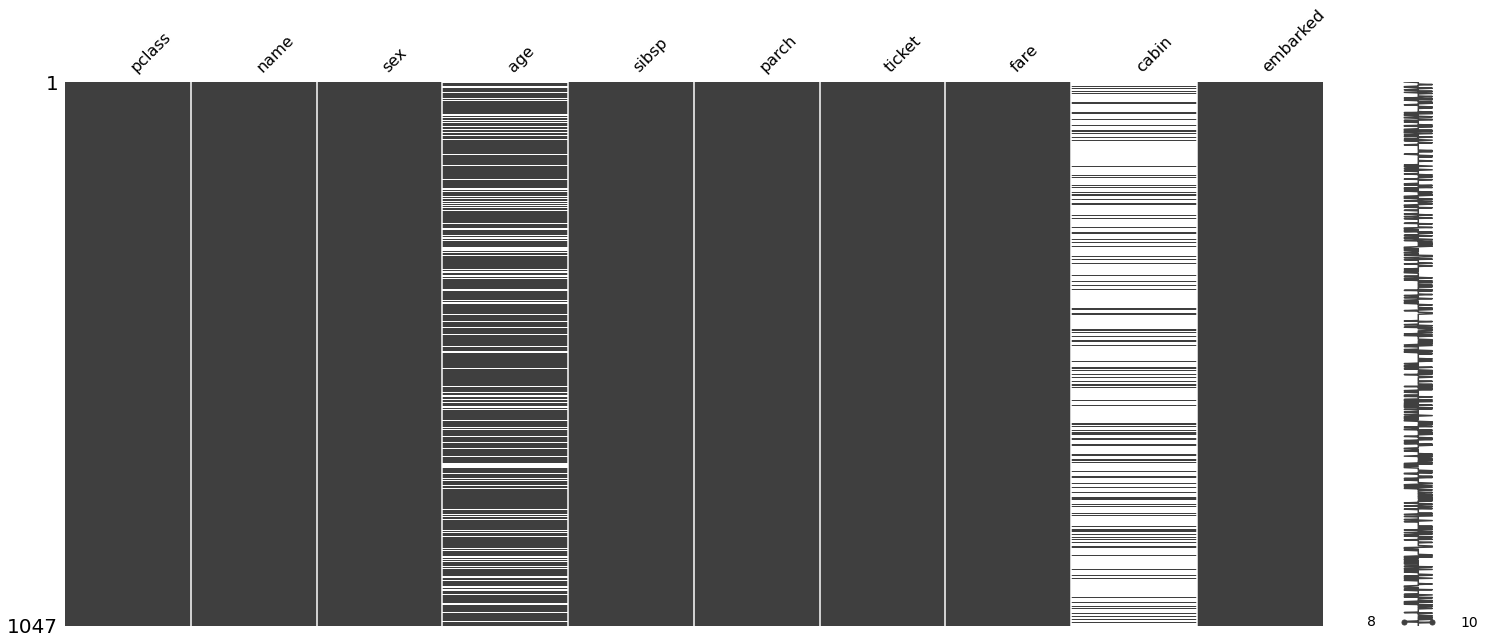

In [6]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

This visualiztion gives us a more intuitive sense of where the values are missing. In this case, the missing values seem to be distributed somewhat evenly or randomly. However, we can also imagine cases were missing values might have something to do with an inherent attribute in the dataset (e.g. only male participants of a survey might reply "N/A" to some health questionaire involving inquiries on pregnancy). In such cases, using this library to visualize where missing values occur is a good idea, as this is an additional dimension of informaiton that calling `df.isnull().sum()` wouldn't be able to reveal.

Now that we have a rough sense of where missing values occur, we need to decide from one of few choices:

* Drop entries with missing values
* Drop columns with too many missing value
* Use imputation to fill missing values with alternate values

Indeed, in this case, we will go ahead and drop the `cabin` attribute. This choice becomes more obvious when we compute the percentage of null values.

In [7]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       78.510029
embarked     0.000000
dtype: float64

This shows us that 77 percent of the rows have missing `cabin` attribute values. Given this information, it's probably a bad idea to try and impute these values. We opt to drop it instead. 

In [31]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Correlation

Correlation (or somewhat equivalently, covariance) is a metric that we always care about, since ultimately the goal of ML engineering is to use a set of input features to generate a prediction. Given this context, we don't want to feed our model useless information that lacks value; instead, we only want to feed into the model highly correlated, relevant, and informative features. If certain features in the raw data are deemed useless, we need to either drop it or engage in some sort of feature engineering to produce a new set of more correlated features. 

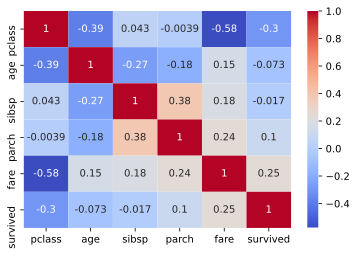

In [9]:
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm")

From this preliminary analysis, it seems like there are some very weekly correlated features, namley `'parch'` and `'sibsp'`. The week correlation suggests that perhaps we need to engage in some feature engineering to extract more meaningful information out of the dataset.

# Feature Engineering

Let's use the findings from the previous section to engineer some more informative features. One popular approach is to make use of names to derive a `title` feature. Intuitively, this makes sense: Mr. and Mrs, Cpt. and Dr. might be of interest for our model. Another popular approach is to combine the less important features---`parch` and `sibsp`---into something like `family_size`. Implementing these should fairly be simple, so let's try it here. 

Note that in an actual setting, there will be no answer to reference; we will have to rely on our own domain knowledge and more extensive EDA to figure out which features matter, and what new features we will need. 



## Family

Sometimes, weakly correlated features can be combined together to form a new feature, which might exhibit higher correlation with respect to the target. We can combine `parch` and `sibsp` into a new feature, called `family_size`. Strictly speaking, we would have to add 1, but adding all values by one corresponds to shifting everything by a constant value, which will not affect modeling since such constant adjustments will be taken care of by the preprocessing step anyway.

Note that feature engineering is also applied to both the training and test set simultaneously.

In [10]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['is_alone'] = 1
    dataset['is_alone'].loc[dataset['family_size'] > 1] = 0

X_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,pclass,name,sex,age,ticket,fare,embarked,family_size,is_alone
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,383123,7.7500,Q,0.0,1
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,SC/PARIS 2167,27.7208,C,1.0,1
628,3.0,"Andersson, Miss. Sigrid Elisabeth",female,11.0,347082,31.2750,S,6.0,0
1165,3.0,"Saad, Mr. Khalil",male,25.0,2672,7.2250,C,0.0,1
604,3.0,"Abelseth, Miss. Karen Marie",female,16.0,348125,7.6500,S,0.0,1


## Title

We have created two new features, namely `family_size` and `is_alone`. Let's go ahead and perform feature engineering on the `name` column as well to squeeze out more information. 

In [11]:
for dataset in [X_train, X_test]:
  dataset['title'] =  dataset['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
  dataset.drop(["name"], axis=1, inplace=True)

X_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pclass,sex,age,ticket,fare,embarked,family_size,is_alone,title
999,3.0,female,NaN,383123,7.7500,Q,0.0,1,Miss
392,2.0,female,24.0,SC/PARIS 2167,27.7208,C,1.0,1,Mrs
628,3.0,female,11.0,347082,31.2750,S,6.0,0,Miss
1165,3.0,male,25.0,2672,7.2250,C,0.0,1,Mr
604,3.0,female,16.0,348125,7.6500,S,0.0,1,Miss


Now we have some data that seems a lot more workable. However, we still have a problem with the `title` column: It seems like there are many titles, so we should probably perform some binning or grouping. 

In [12]:
pd.crosstab(X_train['title'], X_train['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,3
Don,0,1
Dona,1,0
Dr,0,6
Major,0,1
Master,0,51
Miss,210,0
Mlle,2,0


For men, the most common title is `Mr`; for women, `Mrs` and `Miss`. Let's see if there is a difference in the survival rate between the two most common title for females

In [13]:
print(f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}")
print(f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}")

Miss: 0.13371537726838587
Mrs: 0.1174785100286533


It seems like the the difference is insignificant, so we will simply group them together in one. 

In [14]:
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Ms               True
Major            True
Mme              True
the Countess     True
Don              True
Dona             True
Jonkheer         True
Sir              True
Lady             True
Capt             True
Name: title, dtype: bool

In [15]:
for dataset in [X_train, X_test]:
  dataset.title.loc[dataset.title == 'Miss'] = 'Mrs'
  dataset['title'] = dataset.title.apply(lambda x: 'rare' if rare_titles[x] else x)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

In [16]:
for dataset in [X_train, X_test]:
  dataset.drop('ticket', axis=1, inplace=True)

X_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pclass,sex,age,fare,embarked,family_size,is_alone,title
999,3.0,female,NaN,7.7500,Q,0.0,1,Mrs
392,2.0,female,24.0,27.7208,C,1.0,1,Mrs
628,3.0,female,11.0,31.2750,S,6.0,0,Mrs
1165,3.0,male,25.0,7.2250,C,0.0,1,Mr
604,3.0,female,16.0,7.6500,S,0.0,1,Mrs


# Imputation

Imputation refers to a technique used to replace missing values. There are many techniques we can use for imputation. From the analysis above, we know that the columns that require imputation are as follows:

* age
* fare
* embarked

## Data Type Identification

Let's first take a look at the data types for each column.

In [17]:
X_train.dtypes

pclass          float64
sex            category
age             float64
fare            float64
embarked       category
family_size     float64
is_alone          int64
title            object
dtype: object

Checking data types is necessary both for imputation and general data preprocessing. Specifically, we need to pay attention as to whether a given column encodes categorical or numerical variables. For example, we can't use the mean to impute categorical variables; instead, something like the mode would make much more sense. 

The best way to determine whether a variable is categorical or not is simply to use domain knowledge and actually observe the data. Of course, one might use hacky methods like the one below:

In [18]:
def get_cat_cols(df):
  obj_cols = df.columns[df.dtypes == 'object']
  cat_cols = df.columns[df.dtypes == 'category']
  return set(obj_cols).union(set(cat_cols))

cat_cols = get_cat_cols(X_train)
cat_cols

{'embarked', 'sex', 'title'}

Although you might think that this is a working hack, this approach is in fact highly dangerous, even in this toy example. For example, consider `pclass`, which is supposedly a numerical variable of type `float64`. However, earlier with `X_train.head()`, we saw that `pclass` is in fact a ordinal variable taking discrete values, one of 1.0, 2.0, and 3.0. So hacky methods must not be used in isolation; at the very least, they need to be complemented with some form of human input.

## Pipelines

Let's try to use a simple pipeline to deal with missing vallues in some categorical variables. This is going to be our first sneak peak at how pipelines are declared and used.

In [0]:
cat_cols = ['embarked', 'sex', 'pclass', 'title', 'is_alone']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=10))
])

Here, we have declared a three-step pipeline: an imputer, one-hot encoder, and principal component analysis. How this works is fairly simple: the imputer looks for missing values and fills them according to the strategy specified. There are many strategies to choose from, such as most constant or most frequent. Then, we one-hot encode the categorical variables since most machine learning models cannot accept non-numerical values as input. 

The last PCA step might seem extraneous. However, as discussed in [this Stack Overflow thread](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor),

> the judicious combination of one-hot plus PCA can seldom be beat by other encoding schemes. PCA finds the linear overlap, so will naturally tend to group similar features into the same feature.

I don't have enough experience to attest to the veracity of this claim, but mathematically or statistically speaking, this proposition seems valid. The idea is that one-hot encoding all categorical variables may very well lead to an unmanagable number of columns, thus causing one to flaunder in the curse of dimensionality. A quick fix, then, is to apply PCA or some other dimensionality reduction technique onto the results of one-hot encoding. 

Back to the implementation, note that we can look inside the individual components of `cat_transformer` by simply treating it as an iterable, much like a list or tuple. For example,



In [20]:
cat_transformer[0]

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

Next, we need to do something similar for numerical variables. Only this time, we wouldn't be one-hot encoding the data; instead, what we want to do is to apply some scaling, such as normalization or standardization. Recently in one of Andreas Mueller's lectures on YouTube, I learned about the `RobustScaler()`, which uses median and IQR instead of mean and standard deviation as does the `StandardScaler()`. This makes the `RobustScaler()` a superior choice in the presence of outliers. Let's try using it here.

In [0]:
num_cols = ['age', 'fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

Now that we have the two pipelines for numeric and categorical columns, now it's time to put them together into one nice package, then apply the process over the entire dataframe. This packaging can nicely be abstracted via the `ColumnTransformer`, which is the magic glue to put all the pieces together. We simply have to tell which transformer applies to which column, along with the name for each process.

In [0]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

`preprocessor` is the complete package that we will use to transform our data. Note that `ColumnTransformer()` allows us to specify which pipeline will be applied to which column. This is useful, since by default, imputers or transformers apply to the entire dataset. More often or not, this is not what we want; instead, we want to be able to micro-manage categorical and numerical columns. The combination of `pipeline` and `ColumnTransformer` is thus a very powerful one. 

Now all that is left is to build a final pipeline that includes the classifier model. Let's see how well our model performs on a stratified 5-fold cross validation. Note that this is without any hyperparameter tuning. 

In [23]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7630849851902483

And just like that, we can evaluate the performance of our model. 

When it comes to general fitting and testing, a useful tip I found on Kaggle is the following rule of thumb:

* If a pipeilne ends with a transformer, call `fit_transform()` then `transform()`. 
* If a pipeline ends with a model, call `fit()` then `predict()`. Calling `fit()` will cause all steps prior to the model to undergo `fit_transform()`, and the final step---the model---will run `fit()`. 

If you think about it for a second, this configurations makes a lot of sense: if the pipeline contains a model, it means that it is the full package. All the steps prior to the model would involve wrangling the data; the last step would have the model use the data to make a prediction. Therefore, calling `fit()` should apply only to the last model after `fit_transform()` is called on all the preprocessing steps. If the pipeline itself is just a bunddle of preprocessors, on the other hand, we should only be able to call `fit_transform()`. 


# Hyperparameter Search

Scikit-learn's models are great, but in a sense they are too great. This is because there are a lot of hypterparameters to tune. Fortunately for us, we can somewhat resort to a quasi-brute force approach to deal with this: train models on a number of different combinations of hyperparameters and find the one that performs best! Well, this is what `GridSearchCV` does. `RandomSearchCV` is not quite as bad in that it doesn't create and test all possible models that distinct combinations of hyperparameters can yield: instead, it relies on a randomized algorithm to perform a search of the hyperparameter space. This is why `RandomSearchCV` is a lot quicker than `GridSearchCV`, with marginal sacrifices in model performance. 

Let's see how we might be able to perform hyperparameter search given a pipeline like the one we have built above. 

In [0]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100)


The parameter space we are searching for here is by no means exhaustive, but it covers a fair amount of ground. Of course, we can go crazy with randomized search, basically shoving Scikit-learn with every possible configuration and even running a grid search instead. However, that would take an inexorbitant amount of time and computing resources. Therefore, it is important to consider which features are potentially the most important and zoom into these deciding parameters for hypterparameter optimization. 

In [25]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                KNNImputer(add_indicator=False,
                                                                                     

The search took a good five to ten minutes, which is a fair amount of time. Let's take a look at its results. 

In [26]:
random_search.best_score_

0.8022875370243792

We can also take a look at the best parameters that were found. It's worth noting that the algorithm decided that the `KNNImputer()` is supeior to `SimpleImputer()`, which in my opinion is no surprise. However, it is interesting to see our intuition being vindicated in this fashion nonetheless.

In [27]:
random_search.best_params_

{'classifier__bootstrap': True,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 158,
 'preprocessor__cat__imputer__add_indicator': False,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__pca__n_components': 8,
 'preprocessor__num__imputer__add_indicator': True,
 'preprocessor__num__imputer__n_neighbors': 5}

# Model Evaluation

Now it's time for us to evaluate the model. While there are many different metrics we can use, in binary classification, we can look at things like accuracy, precision, recall, and the F1 score. Let's take a look.

In [33]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array(['1', '1', '0', '0', '0'], dtype=object)

The pipeline seems to be working correctly as expected, preprocessing and imputing the data as it was fit on the training data, then generating predictions using the model with optimized parameters. 

Let's see how well our model is doing. One useful function in `sklearn` is the `classification_report()` function, which, as the name implies, gives us a comprehensive report of many widely-used metrics, such as precision, recall, and the F1 score. 

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       162
           1       0.84      0.73      0.78       100

    accuracy                           0.84       262
   macro avg       0.84      0.82      0.83       262
weighted avg       0.84      0.84      0.84       262



The report suggests that the accuracy of our model on the test dataset is about 84 percent. We can manually verify this claim by calculating the accuracy ourselves using boolean indexing.

In [36]:
sum(y_pred == y_test) / len(y_pred)

0.8435114503816794

Let's top this discussion off with a look at the confusion matrix, which is another way of compactly encoding various pieces of information for model evaluation, namely true positives, true negatives, false positives, and false negatives. Note that precision and recall are all metrics that are computed using TP, TN, FP and FN as parameters. The confusion matrix shows that our model performs well at determining the death and survival of those passengers who actually died, but performs rather poorly on those who lived. Analyses like these cannot be obtained simply by looking at accuracy, which is why plotting the confusion matrix is always a good idea to get a sense of the model's performance. 

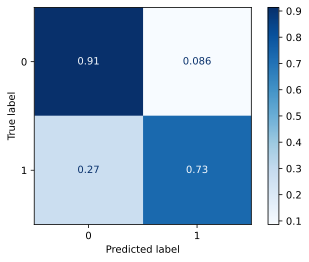

In [43]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(random_search, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()

# Conclusion

Although the titanic dataset is considered trite, much like MNIST is in the context of DL, I still think there is a lot to be learned. Even simpe ML projects like these have inifinite spaces and options for exploration and experimentation. I hope to go through these classic datasets and competitions to glean insight from excellent public kernels, just like [this Kaggle kernel](https://www.kaggle.com/python10pm/sklearn-35-best-tips-and-tricks) which I referenced extensively to write this tutorial. 

In its inception, this post was conceived of as a simple introduction to `sklearn`'s pipelines, but it eventually ballooned up into a somewhat comprehensive rundown of a little Kaggle project. I hope to do a lot more of these in the coming days, just because I think there is immense value in mastering ML, although DL sounds a lot cooler. 

I hope you enjoyed reading this post. Catch you up in the next one!